In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, log_loss
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('utils/')
from data_utils import get_image_folders
from diagnostic_tools import predict, top_k_accuracy, per_class_accuracy,\
    entropy, model_calibration, most_confused_classes, most_inaccurate_k_classes
    
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.benchmark = True

# Load the model

In [4]:
from get_squeezenet import get_model

In [5]:
model, _, _ = get_model()

In [6]:
model.load_state_dict(torch.load('model.pytorch_state'))

# Error analysis

### get all predictions and all misclassified images 

In [7]:
_, val_folder = get_image_folders()

val_iterator_no_shuffle = DataLoader(
    val_folder, batch_size=256, shuffle=False
)

In [8]:
val_predictions, val_true_targets,\
    erroneous_samples, erroneous_targets,\
    erroneous_predictions = predict(model, val_iterator_no_shuffle, return_erroneous=True)
# erroneous_samples: images that were misclassified
# erroneous_targets: their true labels
# erroneous_predictions: predictions for them

100%|██████████| 40/40 [00:41<00:00,  1.13it/s]


### get human readable class names

In [9]:
class_names = pd.read_csv('utils/words.txt', sep='\t', header=None)
class_names.columns = ['code', 'description']

decode = {}
for i, row in class_names.iterrows():
    decode[row.code] = row.description
    

# class index to human readable format
decode = {
    val_folder.class_to_idx[code]: decode[code] 
    for code in val_folder.class_to_idx
}

### number of misclassified images (there are overall 10k images in the val dataset)

In [10]:
n_errors = len(erroneous_targets)
n_errors

3881

### logloss and accuracies

In [11]:
log_loss(val_true_targets, val_predictions)

1.5559206136233577

In [12]:
accuracy_score(val_true_targets, val_predictions.argmax(1))

0.6119

In [13]:
print(top_k_accuracy(val_true_targets, val_predictions, k=(2, 3, 4, 5, 10)))

[0.72699999999999998, 0.7823, 0.81259999999999999, 0.83550000000000002, 0.90100000000000002]


### entropy of predictions

In [14]:
hits = val_predictions.argmax(1) == val_true_targets

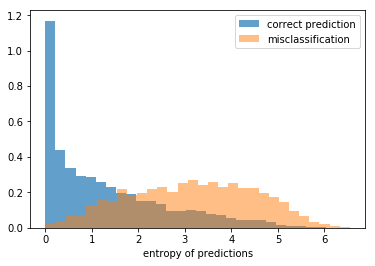

In [15]:
plt.hist(
    entropy(val_predictions[hits]), bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    entropy(val_predictions[~hits]), bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('entropy of predictions');

### confidence of predictions

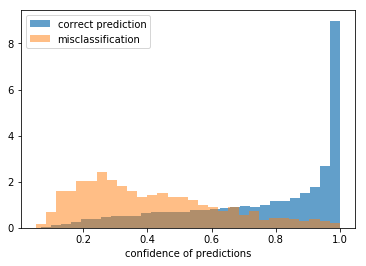

In [16]:
plt.hist(
    val_predictions[hits].max(1), bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    val_predictions[~hits].max(1), bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('confidence of predictions');

### difference between biggest and second biggest probability

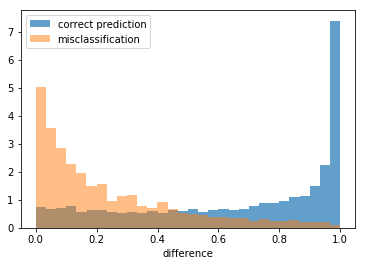

In [17]:
sorted_correct = np.sort(val_predictions[hits], 1)
sorted_incorrect = np.sort(val_predictions[~hits], 1)

plt.hist(
    sorted_correct[:, -1] - sorted_correct[:, -2], bins=30, 
    normed=True, alpha=0.7, label='correct prediction'
);
plt.hist(
    sorted_incorrect[:, -1] - sorted_incorrect[:, -2], bins=30, 
    normed=True, alpha=0.5, label='misclassification'
);
plt.legend();
plt.xlabel('difference');

### probabilistic calibration of the model

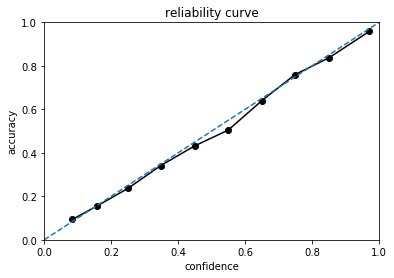

In [18]:
model_calibration(val_true_targets, val_predictions, n_bins=10)

### per class accuracies

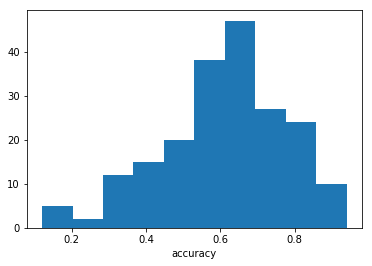

In [19]:
per_class_acc = per_class_accuracy(val_true_targets, val_predictions)
plt.hist(per_class_acc);
plt.xlabel('accuracy');

In [20]:
most_inaccurate_k_classes(per_class_acc, 15, decode)

plunger, plumber's helper 0.12
bow tie, bow-tie, bowtie 0.18
wooden spoon 0.18
syringe 0.18
dumbbell 0.2
bannister, banister, balustrade, balusters, handrail 0.24
ice cream, icecream 0.26
pole 0.3
punching bag, punch bag, punching ball, punchball 0.3
projectile, missile 0.3
cannon 0.32
frying pan, frypan, skillet 0.32
hog, pig, grunter, squealer, Sus scrofa 0.34
water jug 0.34
nail 0.36


### most confused pairs of classes

In [21]:
confused_pairs = most_confused_classes(
    val_true_targets, val_predictions, decode, min_n_confusions=12
)
confused_pairs

[('bullfrog, Rana catesbeiana',
  'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui'),
 ('brain coral', 'coral reef'),
 ('tabby, tabby cat', 'Egyptian cat'),
 ('basketball', 'volleyball'),
 ('beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon',
  'limousine, limo'),
 ('cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM',
  'pay-phone, pay-station'),
 ('convertible', 'sports car, sport car'),
 ('frying pan, frypan, skillet', 'wok'),
 ('orange', 'lemon'),
 ('lakeside, lakeshore', 'seashore, coast, seacoast, sea-coast')]